In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, widgets, fixed
from e_com import *
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter

In [3]:
df = pd.read_csv('Sample-Superstore.csv', encoding='ISO-8859-1')

In [4]:
df["Order Date"] = pd.to_datetime(df["Order Date"])
df["Ship Date"] = pd.to_datetime(df["Ship Date"])

In [5]:
df = gen_product_id(get_cost_price(df))

In [6]:
color = ['#ff9e03', 'g', 'b', 'r', '#ffb300']

In [7]:
text_color = '#ffff00'
face_color = '#222A3588'

sns.set_theme()
sns.set_style('darkgrid')
sns.set(rc={
    'axes.facecolor': face_color,
    "axes.linewidth": 2,
    'axes.edgecolor': text_color,
    "axes.facecolor": face_color,
    'axes.labelsize': 15,
    'axes.titlesize': 15,
    'axes.titlepad': 10,
    'axes.labelcolor': text_color,
    'axes.titlecolor': text_color,
    'xtick.labelsize': 10,
    'xtick.color': text_color,
    'ytick.labelsize': 10,
    'ytick.color': text_color,
    "figure.dpi":200, 
    'savefig.dpi':200,
    'figure.facecolor': face_color,
    'grid.color': text_color,
    'grid.alpha': 0.3,
    'grid.linewidth': 0.5,
    'patch.linewidth': 0.5,
    'patch.edgecolor': text_color,
    'legend.labelcolor': text_color,
    'legend.edgecolor': text_color,
    "text.color": text_color,
    
    }) 

In [8]:
state_orders = df.groupby("State", as_index=False)["Order ID"].count()
state_sales = df.groupby("State", as_index=False)["Sales"].sum()
state_profit = df.groupby("State", as_index=False)["Profit"].sum()
state_customers = df.groupby("State", as_index=False)["Customer ID"].nunique()
state_avg_order = (
    df.groupby(["State", "Order ID"], as_index=False)["Sales"]
    .sum()
    .groupby("State", as_index=False)["Sales"]
    .mean()
)
state_avg_order.rename(columns={"Sales": "Average Order Value"}, inplace=True)
sdf = pd.merge(state_customers, state_profit, on="State")
sdf = pd.merge(sdf, state_avg_order, on="State")
sdf.rename(columns={"Order ID": "Orders", "Customer ID": "Customers"}, inplace=True)

[(0, 15), (1, 5), (2, 17)]


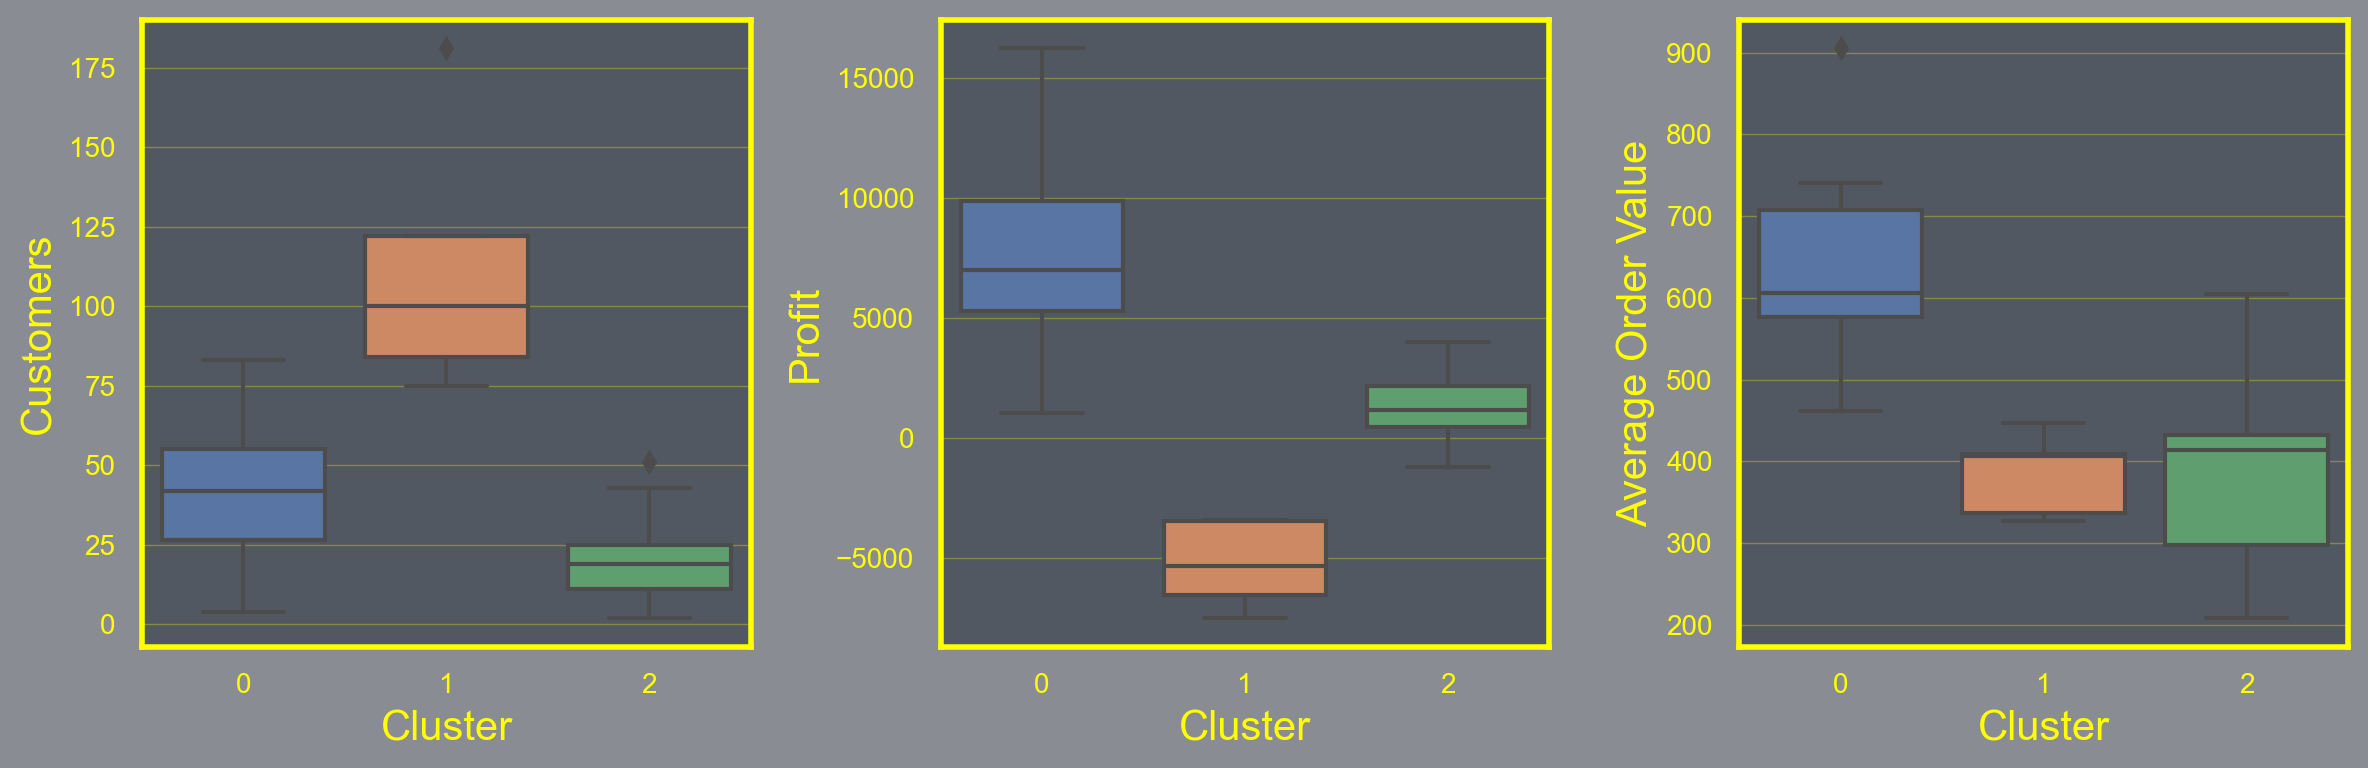

In [9]:
state_clusters = k_clustering(sdf, True, False)

In [10]:
s_clusters = cluster_outliers(get_outliers(sdf), state_clusters)

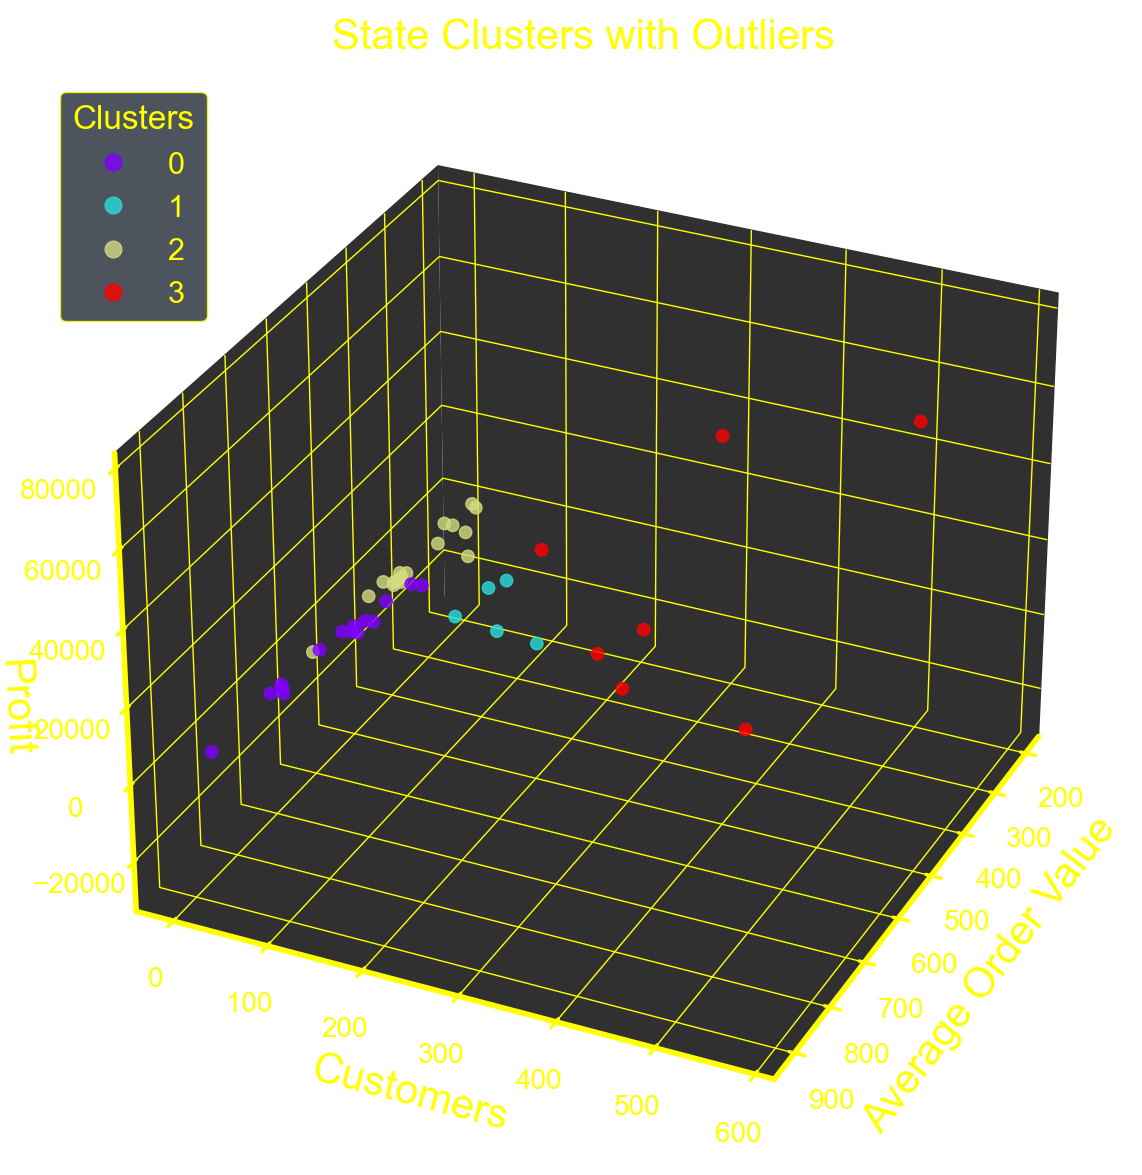

In [11]:
plot_3d(s_clusters, label='State Clusters with Outliers', elev=30, azim=25)

In [12]:
s_clusters[s_clusters['Cluster ID'] == 3].sort_values('Profit', ascending=False)

,State,Customers,Profit,Average Order Value,Cluster ID
3,California,577.0,76381.3871,448.273880,3
30,New York,415.0,74038.5486,553.160625,3
45,Washington,224.0,33402.6517,541.567461,3
11,Illinois,237.0,-12607.8870,290.456888,3
36,Pennsylvania,257.0,-15559.9603,404.555257,3
33,Ohio,202.0,-16971.3766,331.602271,3
41,Texas,370.0,-25729.3563,349.462106,3


In [13]:
state_avg_order['Average Order Value'].mean()

527.27867263376

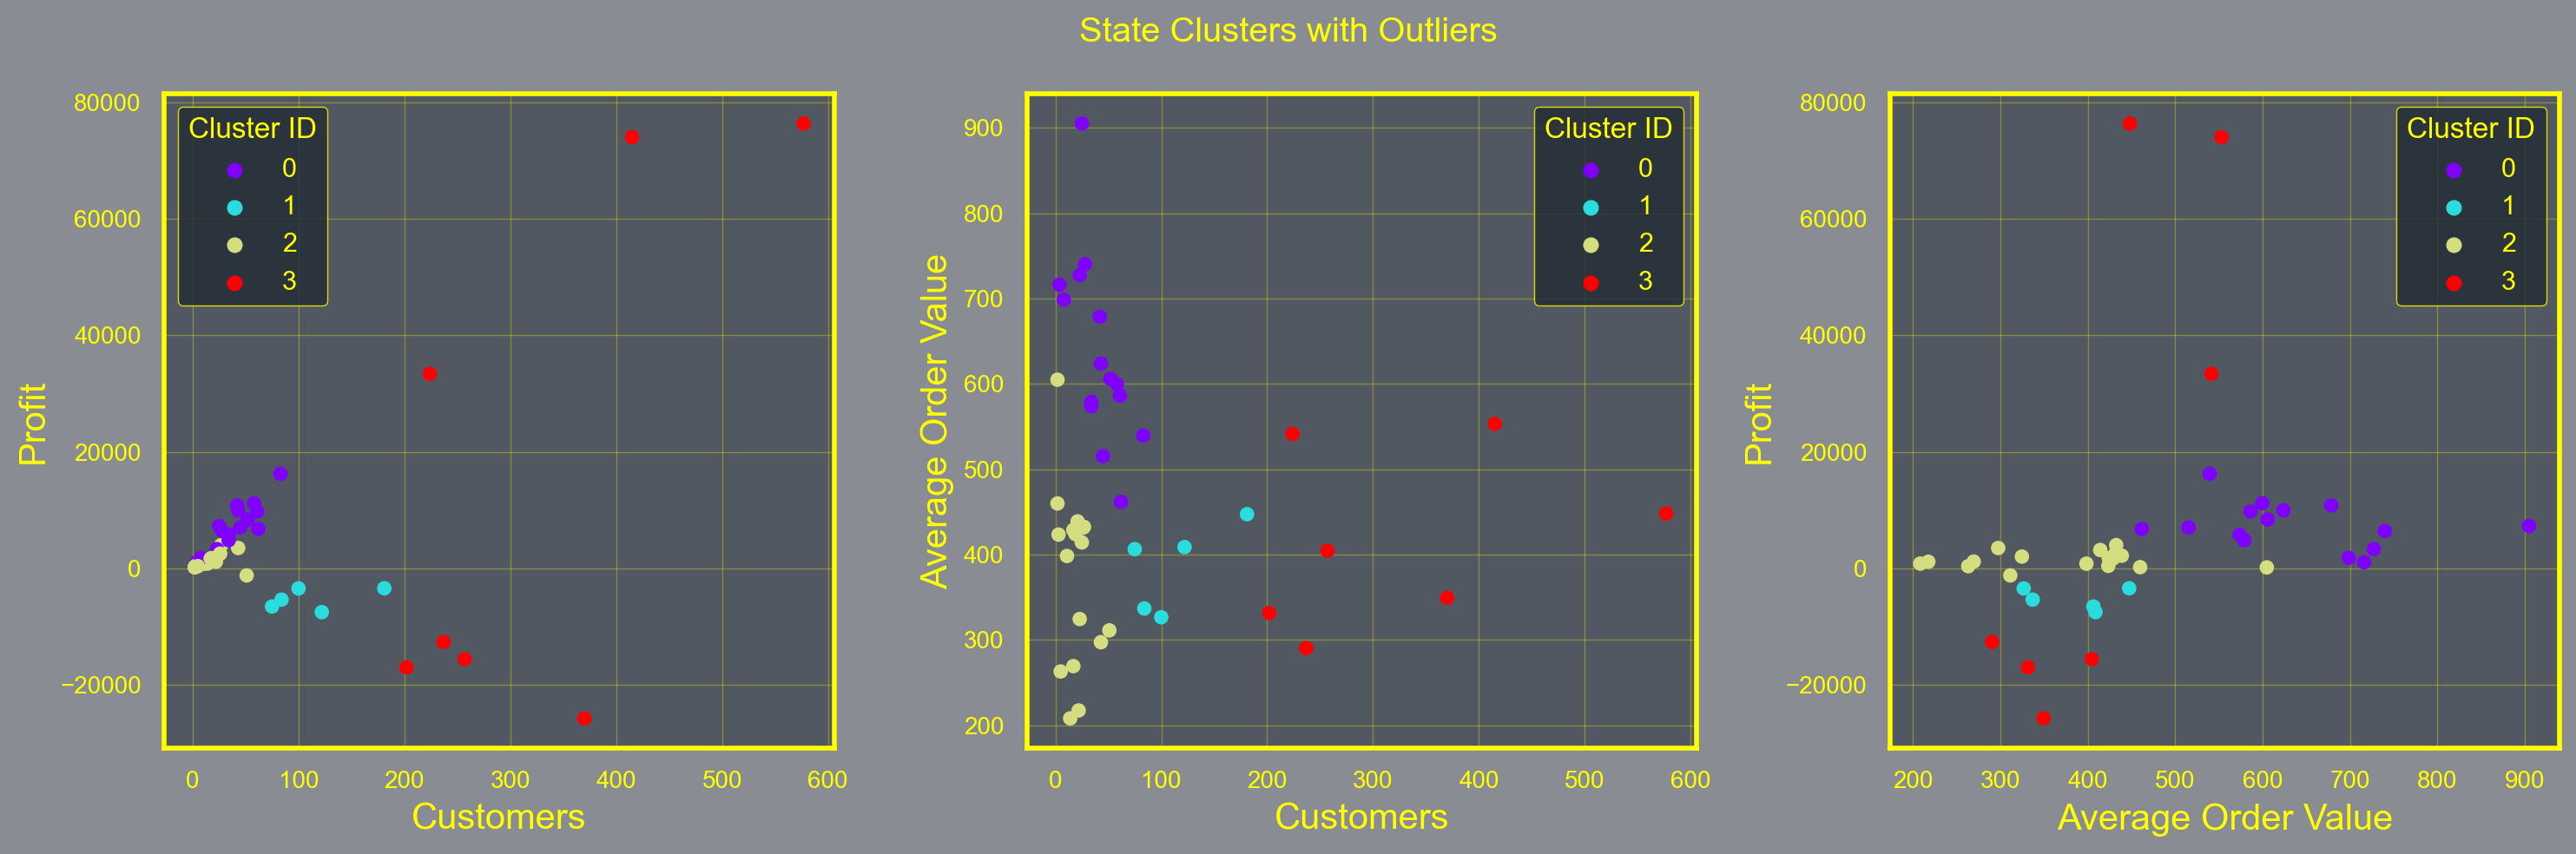

In [14]:
def plane_plots(data, title):

    features = data.columns[1:]

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    for i in range(len(features)-1):
        if i < 2:
            x = features[0]
            y = features[i + 1]
        else:
            x = features[2]
            y = features[1]
        sns.scatterplot(
            data=data,
            x=x,
            y=y,
            hue="Cluster ID",
            palette='rainbow',
            edgecolor='none',
            ax=ax[i]
        )

    fig.suptitle(title)
    plt.tight_layout()

plane_plots(s_clusters, 'State Clusters with Outliers')

In [15]:
customer_orders = df.groupby("Customer ID", as_index=False)["Order ID"].nunique()
customer_sales = df.groupby("Customer ID", as_index=False)["Sales"].sum()
customer_last_order = df.groupby("Customer ID", as_index=False)["Order Date"].max()
customer_last_order["Recency (days)"] = (
    df["Order Date"].max() - customer_last_order["Order Date"]
).dt.days
cdf = pd.merge(customer_orders, customer_sales, on='Customer ID')
cdf = pd.merge(cdf, customer_last_order, on='Customer ID').drop('Order Date', axis=1)
cdf.rename(columns={'Order ID': 'Frequency', 'Sales': 'Sales Amount'}, inplace=True)
cdf

,Customer ID,Frequency,Sales Amount,Recency (days)
0,AA-10315,5,5563.560,184
1,AA-10375,9,1056.390,19
2,AA-10480,4,1790.512,259
3,AA-10645,6,5086.935,55
4,AB-10015,3,886.156,415
...,...,...,...,...
788,XP-21865,11,2374.658,43
789,YC-21895,5,5454.350,4
790,YS-21880,8,6720.444,9
791,ZC-21910,13,8025.707,54


[(0, 252), (1, 109), (2, 311)]


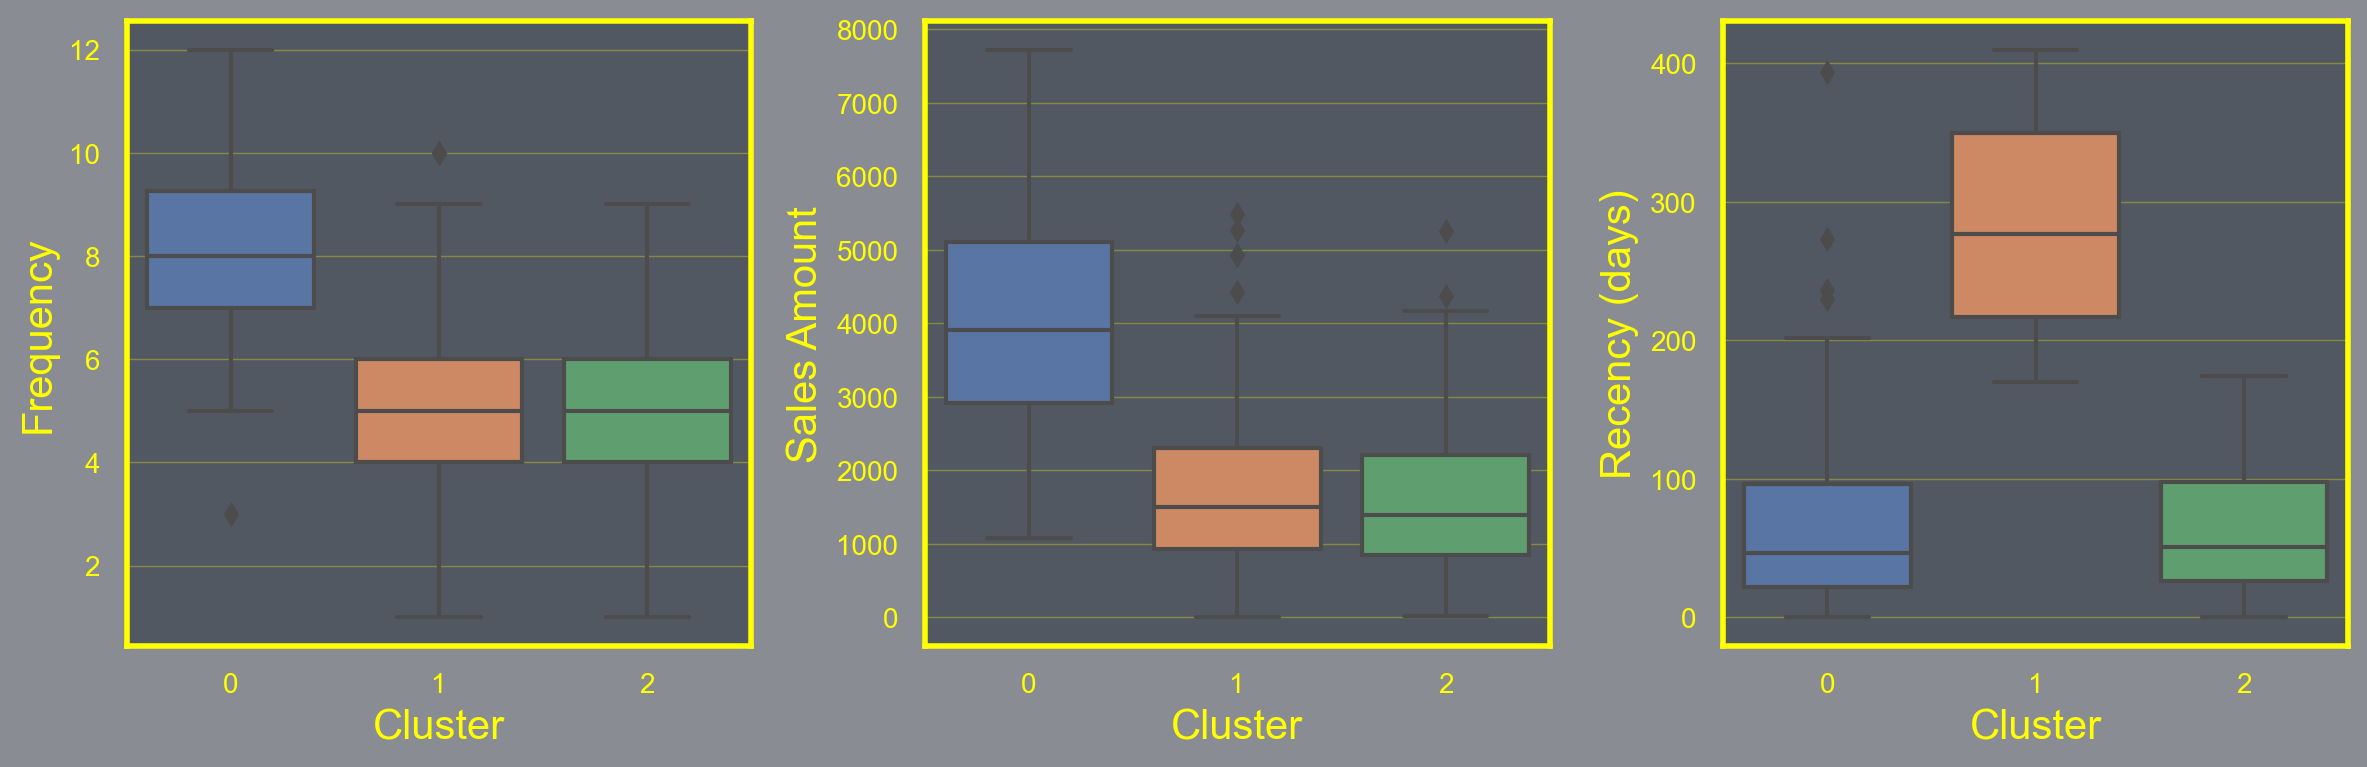

In [16]:
customer_clusters = k_clustering(cdf)

In [17]:
c_clusters = cluster_outliers(get_outliers(cdf), customer_clusters)

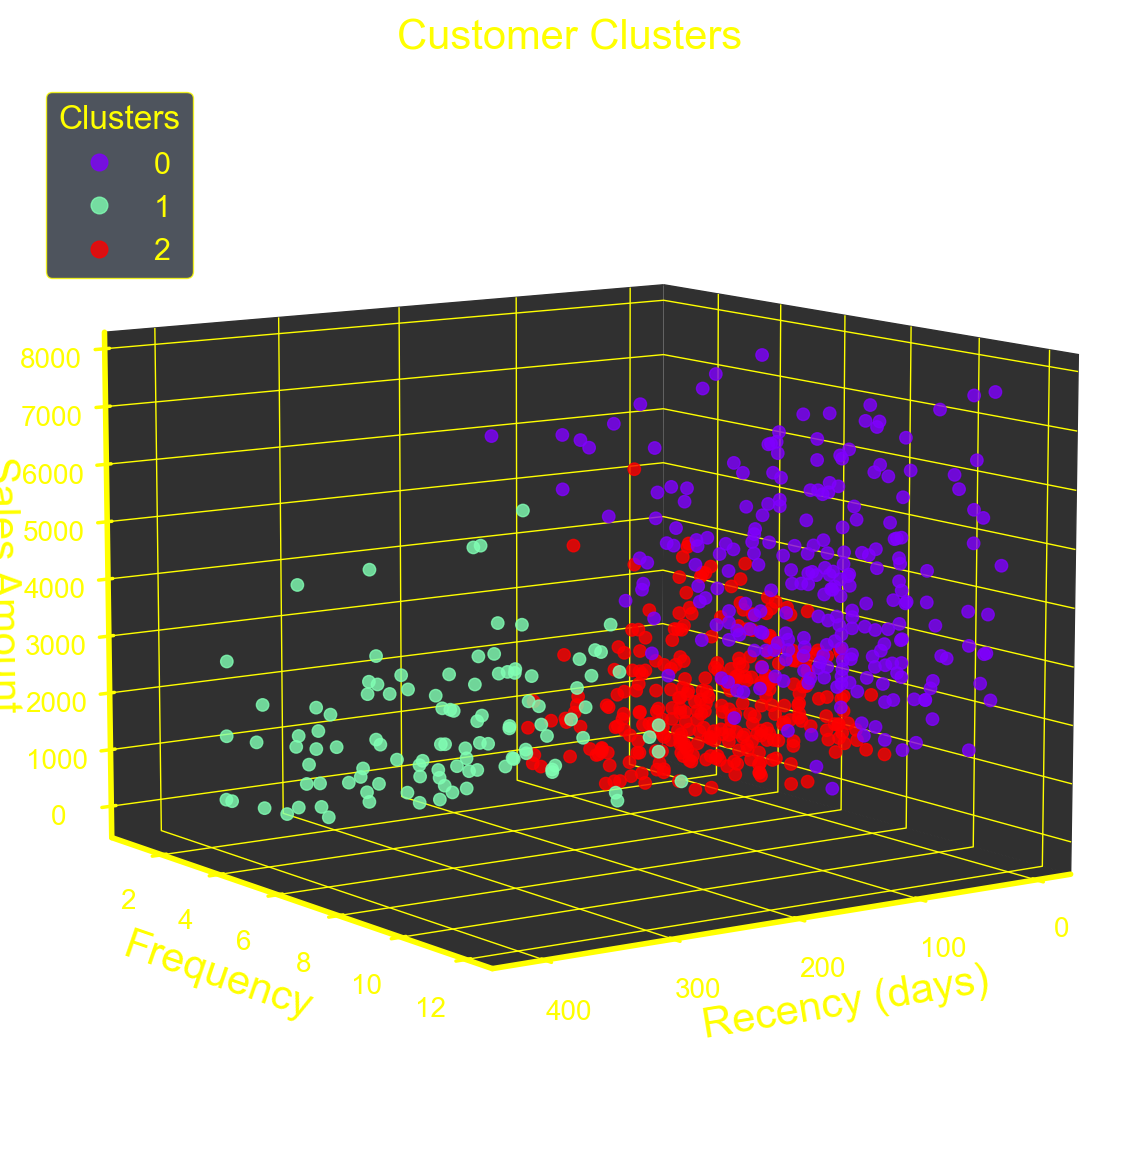

In [18]:
plot_3d(customer_clusters, 'Customer Clusters', elev=10, azim=55)

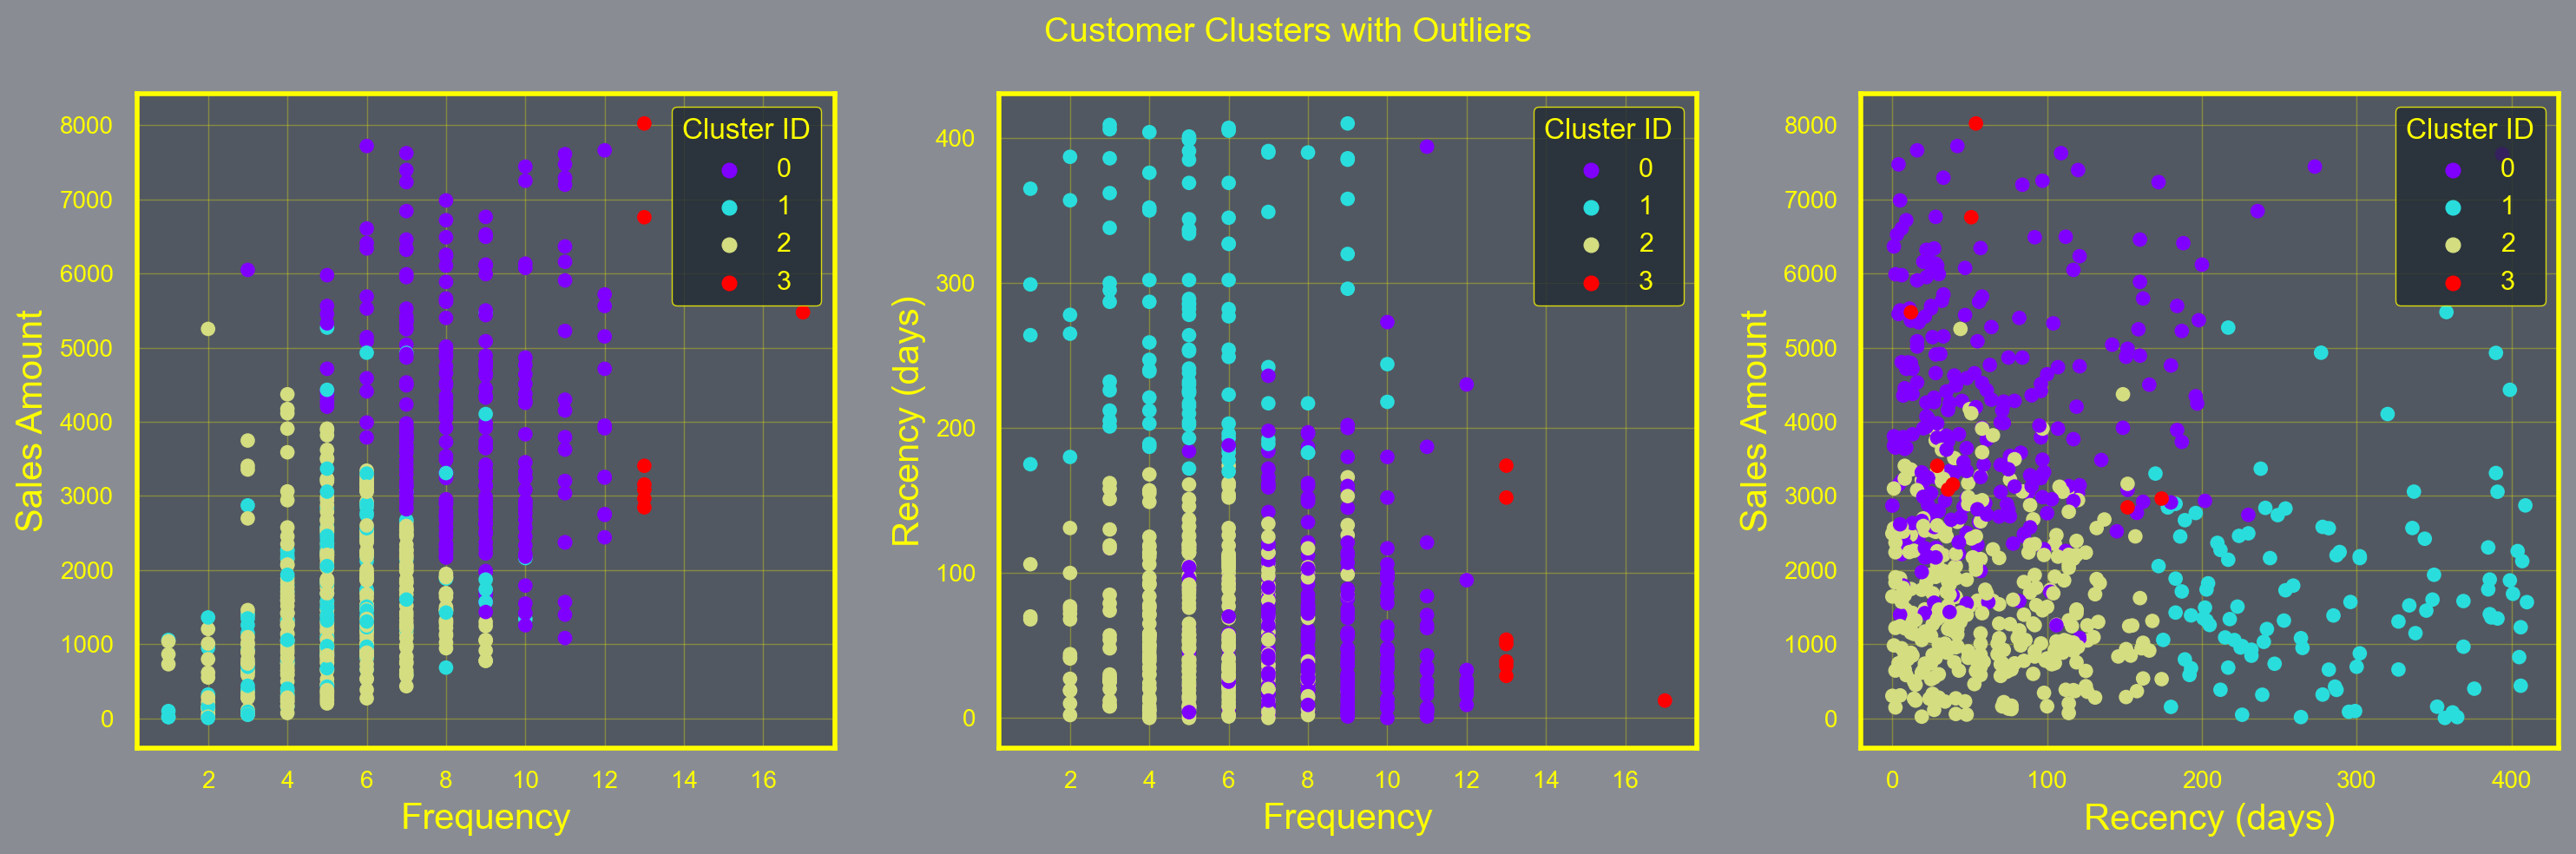

In [19]:
plane_plots(c_clusters, 'Customer Clusters with Outliers')

In [20]:
df["Delivery Time"] = (df["Ship Date"] - df["Order Date"]).dt.days
product_sales = df.groupby("Product ID", as_index=False)["Sales"].sum()
product_orders = df.groupby("Product ID", as_index=False)["Quantity"].sum()
product_del_time = (
    df.groupby("Product ID", as_index=False)["Delivery Time"].mean().round(2)
)
pdf = pd.merge(product_sales, product_orders, on='Product ID')
pdf = pd.merge(pdf, product_del_time, on='Product ID')
pdf

,Product ID,Sales,Quantity,Delivery Time
0,FUR-BO-10000112,825.174,9,2.00
1,FUR-BO-10000330,1064.624,10,1.67
2,FUR-BO-10000362,2154.348,14,4.00
3,FUR-BO-10000468,723.842,21,3.67
4,FUR-BO-10000711,851.760,12,6.50
...,...,...,...,...
1857,TEC-PH-10004912,516.530,11,3.33
1858,TEC-PH-10004922,1085.238,19,4.00
1859,TEC-PH-10004924,56.164,8,2.33
1860,TEC-PH-10004959,341.666,4,3.00


[(0, 407), (1, 223), (2, 425), (3, 524)]


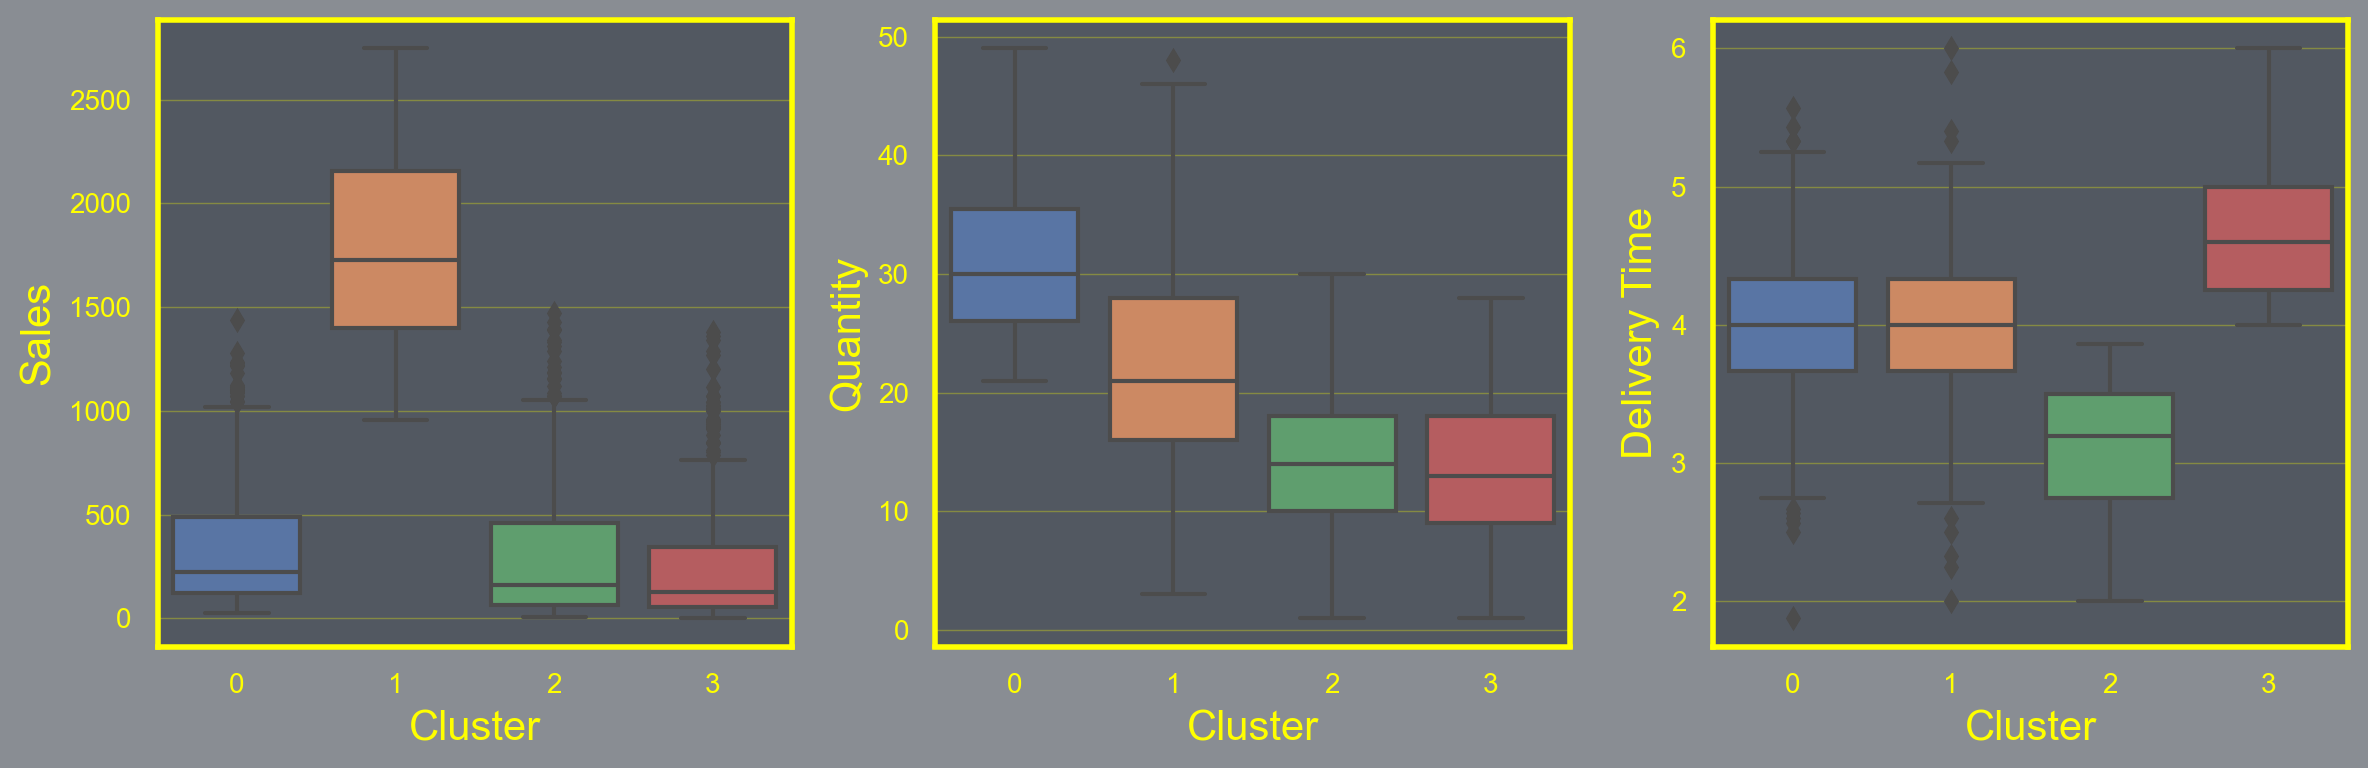

In [21]:
product_clusters = k_clustering(pdf, True, False)

In [22]:
p_outliers = get_outliers(pdf).sort_values(by='Sales')
p_clusters = cluster_outliers(p_outliers[:-1], product_clusters)

In [23]:
p_outliers['Product Name'] = get_names(p_outliers['Product ID'], df)

In [24]:
p_outliers

,Product ID,Sales,Quantity,Delivery Time,Product Name
1590,TEC-AC-10004666,2755.400,10,4.00,Maxell iVDR EX 500GB Cartridge
296,FUR-FU-10004306,2759.060,17,2.67,Electrix Halogen Magnifier Lamp
323,FUR-TA-10001039,2764.257,47,3.64,KI Adjustable-Height Table
1080,OFF-PA-10000994,2789.010,28,4.00,Xerox 1915
1510,TEC-AC-10001908,2799.720,32,3.50,Logitech Wireless Headset h800
...,...,...,...,...,...
691,OFF-BI-10001359,19823.479,37,4.82,GBC DocuBind TL300 Electric Binding System
80,FUR-CH-10002024,21870.576,39,3.12,HON 5400 Series Task Chairs for Big and Tall
1642,TEC-MA-10002412,22638.480,6,5.00,Cisco TelePresence System EX90 Videoconferenci...
776,OFF-BI-10003527,27453.384,31,4.20,Fellowes PB500 Electric Punch Plastic Comb Bin...


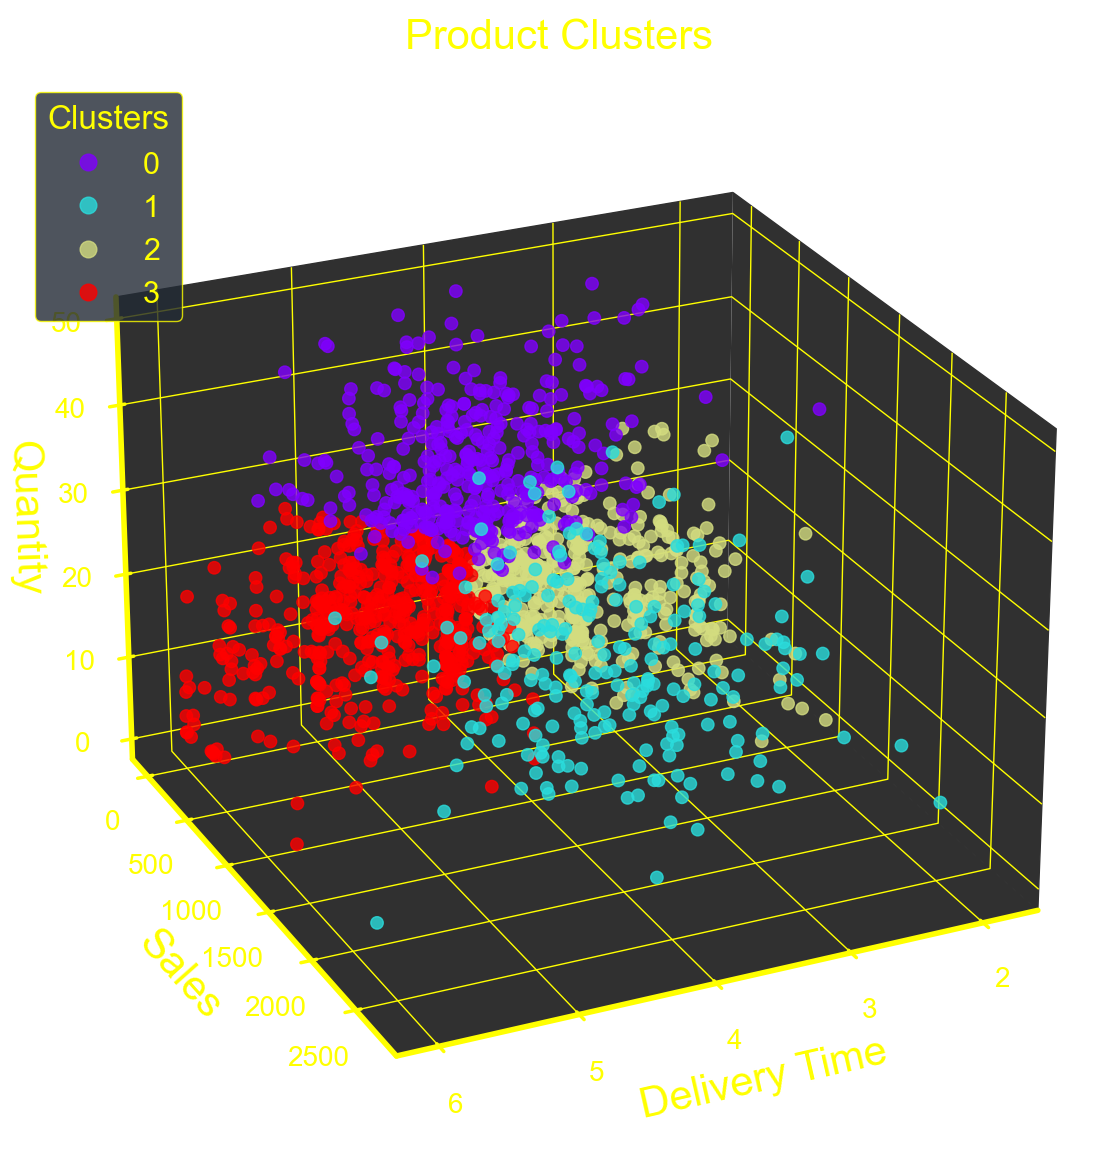

In [25]:
plot_3d(product_clusters, 'Product Clusters', elev=25, azim=65)

In [26]:
interact_3d_plot(p_clusters, 'Products with Outliers')

interactive(children=(IntSlider(value=30, description='Elevation', max=89), IntSlider(value=30, description='A…

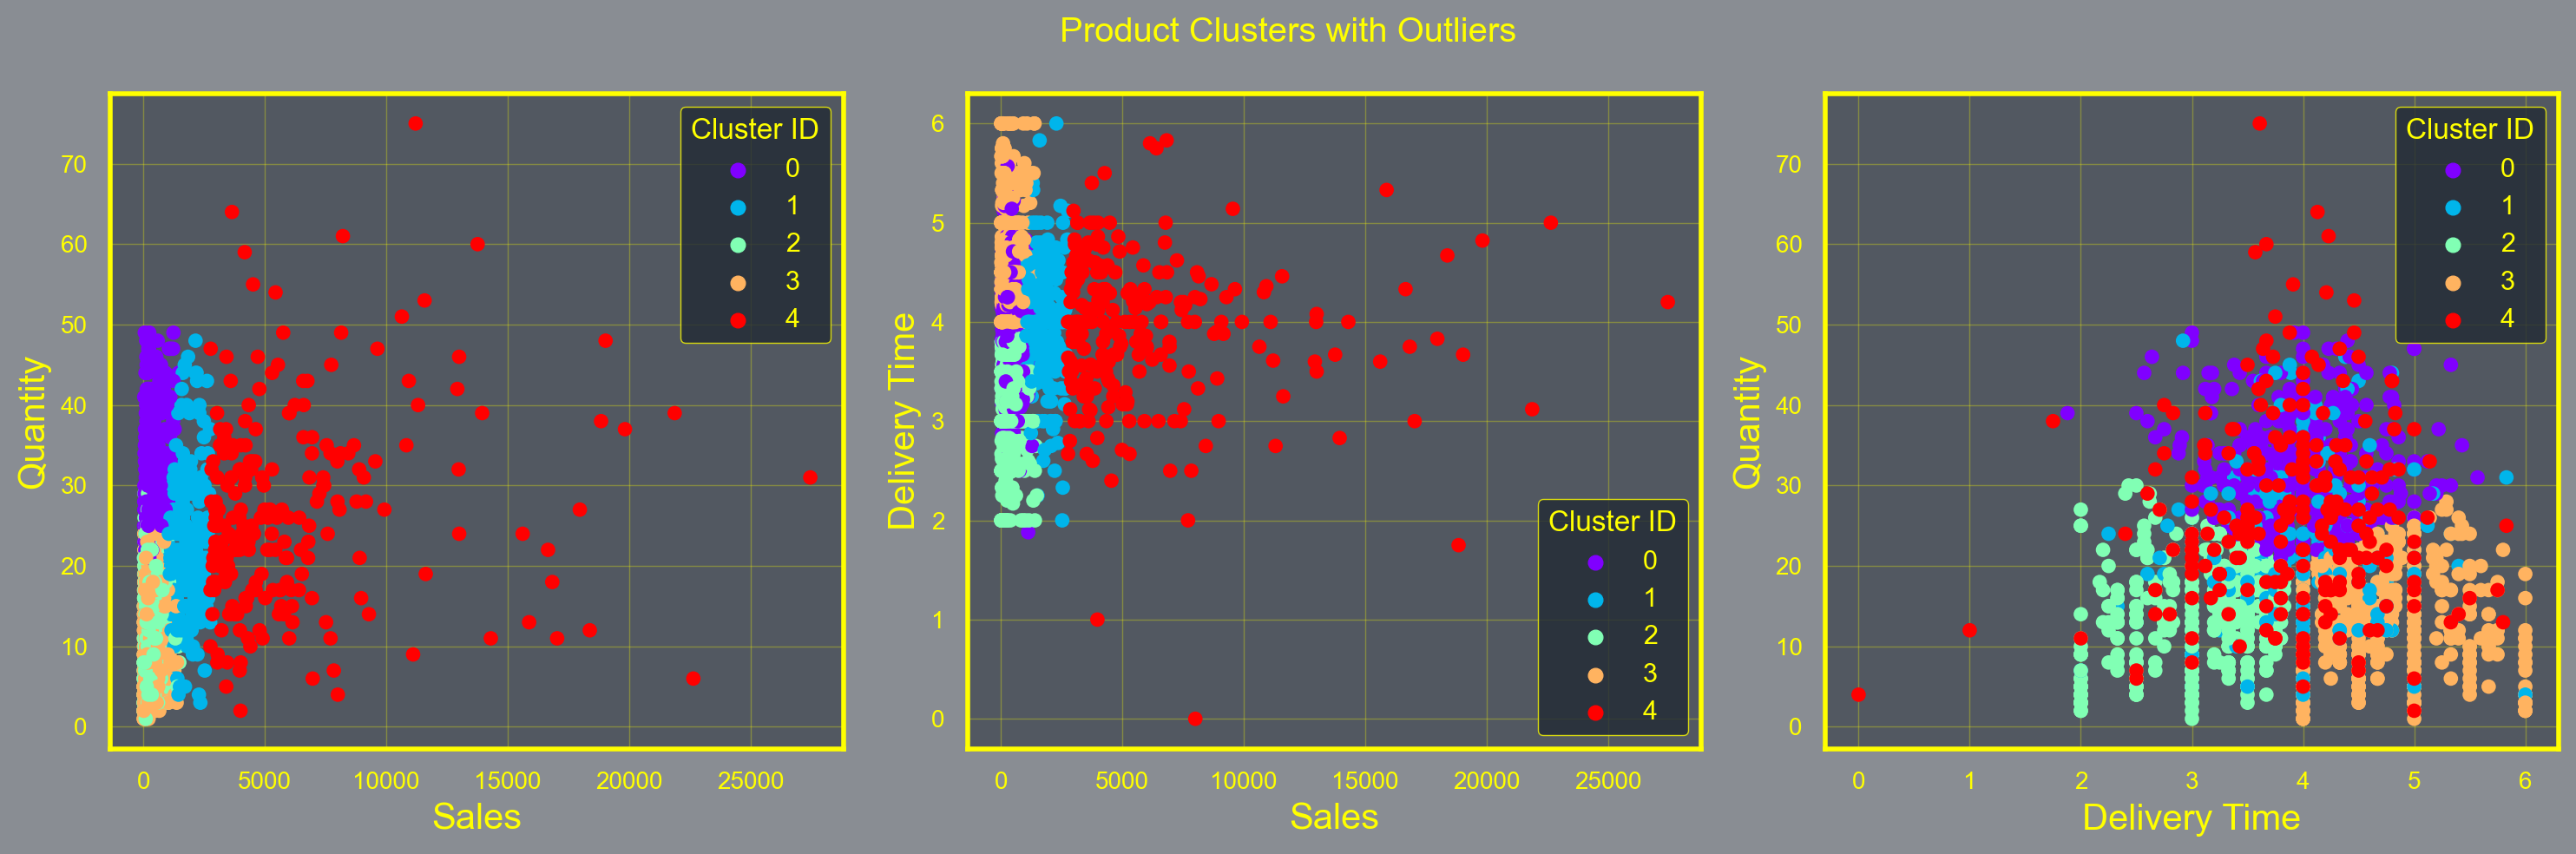

In [27]:
plane_plots(p_clusters, title='Product Clusters with Outliers')

Preparing Data for Apriori algorithm

In [28]:
basket = (
    df[df["Order Date"].dt.year == 2017]
    .groupby(["Order ID", "Product ID"])["Quantity"]
    .sum()
    .unstack()
    .applymap(lambda x: 1 if x > 0 else 0)
    .reset_index()
    .drop("Order ID", axis=1)
)
basket = basket[basket.eq(1).sum(axis=1) > 1]

basket_names = pd.DataFrame(
    [
        [col if val == 1 else np.nan for col, val in row.items()]
        for _, row in basket.iterrows()
    ],
    index=basket.index,
    columns=basket.columns,
)

In [29]:
import json

# records = []
# for i in range(basket_names.shape[0]):
#     records.append([str(basket_names.values[i, j]) for j in range(basket_names.shape[1])])
# with open('records', 'w') as file:
#     json.dump(records, file)
    
with open('records', 'r') as file:
    records = json.load(file)

In [30]:
from apyori import apriori

association_rules = apriori(
    records,
    min_support=0.001,
    min_confidence=0.2,
    min_lift=3,
    min_length=2,
    max_length=2,
)
output = list(association_rules)  # returns a non-tabular output

In [31]:
# Converting output into a pandas dataframe



def inspect(output):

    lhs = [tuple(result[2][0][0])[0] for result in output]
    rhs = [tuple(result[2][0][1])[0] for result in output]
    support = [result[1] for result in output]
    confidence = [result[2][0][2] for result in output]
    lift = [result[2][0][3] for result in output]

    return list(zip(lhs, rhs, support, confidence, lift))



rules_output = (
    pd.DataFrame(
        inspect(output),
        columns=["Left_Hand_Side", "Right_Hand_Side", "Support", "Confidence", "Lift"],
    )
    .replace("nan", np.nan)
    .dropna()
)

In [32]:
rules_output["left_hand_names"] = get_names(
    rules_output.rename(columns={"Left_Hand_Side": "Product ID"})["Product ID"], df
)
rules_output["right_hand_names"] = get_names(
    rules_output.rename(columns={"Right_Hand_Side": "Product ID"})["Product ID"], df
)

In [33]:
rules_output.sort_values(by='Lift', ascending=False)

,Left_Hand_Side,Right_Hand_Side,Support,Confidence,Lift,left_hand_names,right_hand_names
0,FUR-BO-10000112,OFF-AR-10001149,0.001232,1.00,812.000000,"Bush Birmingham Collection Bookcase, Dark Cherry","Sanford Colorific Colored Pencils, 12/Box"
793,FUR-FU-10002508,OFF-BI-10003718,0.001232,1.00,812.000000,Document Clip Frames,GBC Therma-A-Bind 250T Electric Binding System
2884,OFF-PA-10003729,TEC-MA-10000488,0.001232,1.00,812.000000,Xerox 1998,Bady BDG101FRU Card Printer
628,FUR-FU-10000771,OFF-PA-10003739,0.001232,1.00,812.000000,"Eldon 200 Class Desk Accessories, Smoke",Xerox 1969
2479,OFF-FA-10001561,TEC-AC-10001383,0.001232,1.00,812.000000,Stockwell Push Pins,Logitech Wireless Touch Keyboard K400
...,...,...,...,...,...,...,...
1186,FUR-TA-10003473,TEC-AC-10003832,0.001232,0.25,33.833333,Bretford Rectangular Conference Table Tops,Logitech P710e Mobile Speakerphone
1878,OFF-BI-10000404,OFF-ST-10001325,0.001232,0.25,33.833333,Avery Printable Repositionable Plastic Tabs,Sterilite Officeware Hinged File Box
452,FUR-CH-10003973,OFF-PA-10001970,0.001232,0.25,29.000000,GuestStacker Chair with Chrome Finish Legs,Xerox 1881
2783,TEC-PH-10004447,OFF-PA-10001970,0.001232,0.25,29.000000,Toshiba IPT2010-SD IP Telephone,Xerox 1881
